In [1]:
!pip install torchmetrics[image]
!pip install gdown

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as T
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.parametrizations import spectral_norm as SpectralNorm
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.backends.cudnn.benchmarks = True

import random
import numpy as np
import os
import torchvision
from torchvision.utils import save_image
from scipy.stats import truncnorm

import torchinfo
import os, shutil
import zipfile
import gdown
import matplotlib.pyplot as plt
import math

2024-05-29 02:15:34.417285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 02:15:34.417403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 02:15:34.537502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class GANOptions:
    def __init__(self, image_size=64, latent_dim=128, batch_size=32, n_epochs=10, data_path="", output_path="") -> None:
        self.num_epochs = n_epochs
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.label_softness = 0.1
        self.num_classes = 20

        self.data_path = data_path
        self.image_size = image_size
        self.img_ch = 3

        self.output_path = output_path
        self.save_interval = 100
        self.fid_interval = 100
        self.save_checkpoint = True
        self.load_checkpoint = False

        self.generator_frequency = 1
        self.generator_bn = True
        self.generator_lr = 2e-4
        self.generator_beta1 = 0.5
        self.generator_beta2 = 0.999
        self.weight_decay = 2.5e-5

        self.discriminator_frequency = 1
        self.discriminator_bn = True
        self.discriminator_lr = 2e-4
        self.discriminator_beta1 = 0.5
        self.discriminator_beta2 = 0.999
        self.discriminator_kernel = 5
        

In [4]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False, eps=1e-04)
        self.embedding = SpectralNorm(nn.Embedding(num_classes, num_features * 2))

        self.embedding.weight.data[:, :num_features].fill_(1.)
        self.embedding.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        shape = y.shape
        if len(shape) == 1:
            embed = self.embedding(y)
        else:
            y = y.type(self.embedding.weight.data.dtype)
            embed = y.matmul(self.embedding.weight.data)

        gain, bias = embed.chunk(2, 1)
        gain = gain.view(-1, self.num_features, 1, 1)
        bias = bias.view(-1, self.num_features, 1, 1)
        out = gain * out + bias
        return out


def sp_conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return SpectralNorm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))


class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super(NonLocalBlock, self).__init__()

        self.channels = in_channels

        self.theta = SpectralNorm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, stride=1, padding=0, bias=False))

        self.phi = SpectralNorm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1, stride=1, padding=0, bias=False))

        self.g = SpectralNorm(nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, stride=1, padding=0, bias=False))

        self.o = SpectralNorm(nn.Conv2d(in_channels // 2, in_channels, kernel_size=1, stride=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
    def forward(self, x, *args):
        img_size = x.shape[2] * x.shape[3]
        
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        theta = theta.view(-1, self.channels // 8, img_size)
        phi = phi.view(-1, self.channels // 8, img_size // 4)
        g = g.view(-1, self.channels // 2, img_size // 4)

        beta = F.softmax(torch.bmm(theta.permute(0, 2, 1), phi), dim=-1)

        o = self.o(torch.bmm(g, beta.permute(0, 2, 1))
                   .view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        z = self.gamma * o + x

        return z
    

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 conv=nn.Conv2d, batch_norm=nn.BatchNorm2d,
                 num_classes=10, channel_ratio=4, use_bn=True,
                 upsample=False, downsample=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = out_channels // channel_ratio
        if self.hidden_channels <= 0:
            self.hidden_channels = out_channels
        self.num_classes = num_classes

        self.use_bn = use_bn
        self.upsample = upsample
        self.downsample = downsample
        self.activation = nn.ReLU(True)

        self.conv1 = nn.Sequential(
            nn.ReplicationPad2d(1),
            SpectralNorm(conv(self.in_channels, self.hidden_channels,
                          kernel_size=3, stride=1, padding=0,
                          bias=False if use_bn else True))
        )
        self.conv2 = nn.Sequential(
            nn.ReplicationPad2d(1),
            SpectralNorm(conv(self.hidden_channels, self.out_channels,
                          kernel_size=3, stride=1, padding=0,
                          bias=False if use_bn else True))
        )

        self.skip_proj = False
        if in_channels != out_channels or upsample or downsample:
            self.conv_skip = SpectralNorm(conv(in_channels, out_channels,
                                                     1, 1, 0))
            self.skip_proj = True
        

        self.bn1 = batch_norm(self.in_channels) if use_bn else None
        self.bn2 = batch_norm(self.hidden_channels) if use_bn else None

    def forward(self, x, *args):
        out = x

        if self.use_bn:
            out = self.bn1(out)
        
        out = self.activation(out)

        if self.upsample:
            out = F.interpolate(out, scale_factor=2, align_corners=False, mode="bilinear")
        
        out = self.conv1(out)

        if self.use_bn:
            out = self.bn2(out)

        out = self.activation(out)

        out = self.conv2(out)

        if self.downsample:
            out = F.avg_pool2d(out, kernel_size=2, stride=2)

        skip = x
        if self.skip_proj:
            if self.upsample:
                skip = F.interpolate(skip, scale_factor=2, align_corners=False, mode="bilinear")

            skip = self.conv_skip(skip)

            if self.downsample:
                skip = F.avg_pool2d(skip, kernel_size=2, stride=2)

        return out + skip
    

class Upblock(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes, ratio=4, scale_factor=2):
        super().__init__()
        hidden_channels = out_channels // ratio
        if hidden_channels <= 0:
            hidden_channels = out_channels
        self.relu = nn.ReLU(True)
        self.upsample = Upsample(scale_factor=scale_factor)

        self.conv1 = sp_conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = sp_conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.bn1 = ConditionalBatchNorm2d(hidden_channels, num_classes)
        self.bn2 = ConditionalBatchNorm2d(out_channels, num_classes)
    
    def forward(self, x, y):
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.relu(self.bn1(x, y))

        x = self.conv2(x)
        x = self.relu(self.bn2(x, y))

        return x
    

class Downblock(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=4, downsample_ratio=2):
        super().__init__()
        hidden_channels = out_channels // ratio 
        if hidden_channels <= 0:
            hidden_channels = out_channels

        leaky_relu = nn.LeakyReLU()
        self.downsample = Downsample(ratio=downsample_ratio)
        self.conv1 = nn.Sequential(
            sp_conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            leaky_relu
        )
        self.conv2 = nn.Sequential(
            sp_conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1),
            leaky_relu
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.downsample(x)
        return x


class Generator(nn.Module):
    
    def __init__(self, z_dim=128, img_size=64, img_ch=3, num_classes=10, ch=32, G_shared=True):
        super().__init__()
        self.img_size=img_size
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.embedding_dim = 128
        self.ch = ch

        self.architectures = {
            64: {
                "in_channels": [16, 16, 8, 4],
                "out_channels": [16, 8, 4, 2]
            },
            128: {
                "in_channels": [16, 16, 8, 4, 2],
                "out_channels": [16, 8, 4, 2, 1]
            },
            256: {
                "in_channels": [16, 16, 8, 8, 4, 2],
                "out_channels": [16, 8, 8, 4, 2, 1]
            }
        }
        self.architecture = self.architectures[self.img_size]

        self.G_shared = G_shared

        self.embedding = SpectralNorm(nn.Embedding(self.num_classes, self.embedding_dim)) if self.G_shared else nn.Sequential()
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
        n_classes = self.z_dim + self.embedding_dim if self.G_shared else self.num_classes

        self.init = nn.Sequential(
            SpectralNorm(torch.nn.ConvTranspose2d(self.z_dim + self.embedding_dim if self.G_shared else self.z_dim, 
                                     self.architecture["in_channels"][0] * self.ch, kernel_size=4, stride=1, padding=0, bias=False)),
            torch.nn.BatchNorm2d(self.architecture["in_channels"][0] * self.ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(0.1, inplace=True)
        )
        self.n_blocks = len(self.architecture["in_channels"])
        blocks = []
    
        for i in range(4):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [ResBlock(in_channels, out_channels, num_classes=n_classes, upsample=True)]
        
        non_local_in_channels = self.architecture["out_channels"][3] * self.ch
        blocks += [NonLocalBlock(non_local_in_channels)]

        for i in range(4, self.n_blocks):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [ResBlock(in_channels, out_channels, num_classes=n_classes, upsample=True)]
        
        final_out_channels = self.architecture["out_channels"][-1] * self.ch
        blocks += [
            ConditionalBatchNorm2d(final_out_channels, n_classes),
        ]
        self.blocks = nn.ModuleList(blocks)

        self.output = nn.Sequential(
            nn.ReLU(True),
            sp_conv2d(final_out_channels, self.img_ch),
            nn.Tanh()
        )

    def forward(self, z, y):
        if self.G_shared:
            shape = y.shape
            if len(shape) == 1:
                embed = self.embedding(y)
            else:
                y = y.type(self.embedding.weight.data.dtype)
                embed = y.matmul(self.embedding.weight.data)

            z = torch.cat([embed, z], 1)
            y = z

        z = z.unsqueeze(-1).unsqueeze(-1)

        z = self.init(z)

        for index, block in enumerate(self.blocks):
            z = block(z, y)

        return self.output(z)


class Discriminator(nn.Module):
    
    def __init__(self, img_size=64, img_ch=3, num_classes=10, ch=32):
        super().__init__()
        self.img_size=img_size
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.embedding_dim = 128
        self.ch = ch

        self.architectures = {
            64: {
                "in_channels": [1, 2, 4, 8],
                "out_channels": [2, 4, 8, 16]
            },
            128: {
                "in_channels": [1, 2, 4, 8, 16],
                "out_channels": [2, 4, 8, 16, 16]
            },
            256: {
                "in_channels": [1, 2, 4, 8, 8, 16],
                "out_channels": [2, 4, 8, 8, 16, 16]
            }
        }
        self.architecture = self.architectures[self.img_size]

        in_channels = self.architecture["in_channels"][0] * self.ch
        self.init = nn.Sequential(
            sp_conv2d(self.img_ch, in_channels)
        )

        self.n_blocks = len(self.architecture["in_channels"])
        blocks = []

        for i in range(self.n_blocks - 4):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [ResBlock(in_channels, out_channels, use_bn=False, downsample=True)]

        non_local_in_channels = self.architecture["in_channels"][self.n_blocks - 4] * self.ch

        blocks += [NonLocalBlock(non_local_in_channels)]

        for i in range(self.n_blocks - 4, self.n_blocks):
            in_channels = self.architecture["in_channels"][i] * self.ch
            out_channels = self.architecture["out_channels"][i] * self.ch
            blocks += [ResBlock(in_channels, out_channels, use_bn=False, downsample=True)]
        
        blocks += [ResBlock(out_channels, out_channels, use_bn=False, downsample=False)]
        
        self.net = nn.Sequential(*blocks)

        self.relu = nn.ReLU(True)
        final_out_channels = self.architecture["out_channels"][-1] * self.ch
        self.linear = SpectralNorm(nn.Linear(final_out_channels, 1))
        self.embedding = SpectralNorm(nn.Embedding(self.num_classes, self.architecture["out_channels"][-1] * self.ch))
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y):
        x = self.init(x)

        x = self.net(x)

        # global sum pooling
        x = torch.sum(self.relu(x), (2,3))

        out = self.linear(x)
        shape = y.shape
        if len(shape) == 1:
            embed = self.embedding(y)
        else:
            y = y.type(self.embedding.weight.data.dtype)
            embed = y.matmul(self.embedding.weight.data)

        proj = torch.sum(embed * x, dim=1, keepdim=True)
        out = out + proj
        return out

In [5]:
z = torch.randn(16, 100).to(device)

y = torch.randint(0, 10, (16,)).to(device)

gen = Generator(100, 64).to(device)

fake1  = gen(z, y)
print(fake1.shape)

torchinfo.summary(gen, input_data=(z, y), col_names = ("input_size", "output_size", "num_params"))

torch.Size([16, 3, 64, 64])


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
Generator                                                    [16, 100]                 [16, 3, 64, 64]           --
├─ParametrizedEmbedding: 1-1                                 [16]                      [16, 128]                 --
│    └─ModuleDict: 2-1                                       --                        --                        --
│    │    └─ParametrizationList: 3-1                         --                        [10, 128]                 1,280
├─Sequential: 1-2                                            [16, 228, 1, 1]           [16, 512, 4, 4]           --
│    └─ParametrizedConvTranspose2d: 2-2                      [16, 228, 1, 1]           [16, 512, 4, 4]           --
│    │    └─ModuleDict: 3-2                                  --                        --                        1,867,776
│    └─BatchNorm2d: 2-3                                  

In [6]:
disc = Discriminator(64).to(device)

fake_pred = disc(fake1, y)
print(fake_pred.shape)


torchinfo.summary(disc, input_data=(fake1, y), col_names = ("input_size", "output_size", "num_params"))

torch.Size([16, 1])


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #
Discriminator                                                [16, 3, 64, 64]           [16, 1]                   --
├─Sequential: 1-1                                            [16, 3, 64, 64]           [16, 32, 64, 64]          --
│    └─ParametrizedConv2d: 2-1                               [16, 3, 64, 64]           [16, 32, 64, 64]          32
│    │    └─ModuleDict: 3-1                                  --                        --                        864
├─Sequential: 1-2                                            [16, 32, 64, 64]          [16, 512, 4, 4]           --
│    └─NonLocalBlock: 2-2                                    [16, 32, 64, 64]          [16, 32, 64, 64]          1
│    │    └─ParametrizedConv2d: 3-2                          [16, 32, 64, 64]          [16, 4, 64, 64]           128
│    │    └─ParametrizedConv2d: 3-3                          [16, 

In [7]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
    
def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in', nonlinearity='leaky_relu')
#     elif classname.find('BatchNorm') != -1:
#         nn.init.constant_(m.weight.data, 1.0)
#         nn.init.constant_(m.bias.data, 0.0)


def interpolate(batch):
    return F.interpolate(batch, (299, 299), mode="bilinear")




# clear folder
def clear_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


# make archieve
def make_zip(
        output_filename = "/kaggle/working/images28",
        dir_name = "/kaggle/working/images"
):
    shutil.make_archive(output_filename, 'zip', dir_name)

def unzip_file(
        file="/kaggle/working/game_scenes.zip",
        path_to_unzip="/kaggle/working/"
):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall(path_to_unzip)
    zip_ref.close()

# download from gdrive
def download_from_drive(
    url = "https://drive.google.com/us?id=17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY",
    output = "game_scenes.zip"
):
    # 2d_game_scenes.zip
    # https://drive.google.com/file/d/17Z7_Fli_vgYuxO8JUoZICCiihG0sXYEY/view?usp=drive_link

    gdown.download(url, output, quiet=False, fuzzy=True)


def remove(path):
    os.remove(path)


# utils
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, fid, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)
    writer.add_scalar("FID", fid, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, z_dim, labels, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, z_dim, 1, 1)), device=device, dtype=torch.float32)
            img = gen(noise)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()


In [8]:
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

policy = 'color,translation,cutout'

In [ ]:
# remove("/kaggle/working/kth.zip")

In [9]:
seed_everything(1000)

In [10]:
steps = []
fids_steps = []
d_losses = []
g_losses = []
fids = []

def clear_lists():
    steps.clear()
    fids_steps.clear()
    d_losses.clear()
    g_losses.clear()
    fids.clear()

In [11]:
def gan_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

In [19]:
download_from_drive("https://drive.google.com/file/d/1m9O6QKMxS1ZrNfF0yq6wdSscrKBmDpON/view?usp=drive_link")

unzip_file()

Downloading...
From (original): https://drive.google.com/uc?id=1m9O6QKMxS1ZrNfF0yq6wdSscrKBmDpON
From (redirected): https://drive.google.com/uc?id=1m9O6QKMxS1ZrNfF0yq6wdSscrKBmDpON&confirm=t&uuid=d9745233-c435-4245-9e7b-0c89d340d916
To: /kaggle/working/game_scenes.zip
100%|██████████| 550M/550M [00:03<00:00, 150MB/s] 


In [13]:
# remove("/kaggle/working/game_scenes.zip")

In [21]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, root_dir, img_ends='.jpg', text_transform=None, image_transform=None):
        self.root_dir = root_dir

        self.dataset = ImageFolder(root_dir, 
                               transform=image_transform)
        
        self.classes = []

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]

        return image[0], torch.tensor(idx // 10, dtype=torch.long)

In [22]:
class SAGAN:
    def __init__(self, options: GANOptions) -> None:
        self.G = Generator(options.latent_dim, options.image_size, num_classes=options.num_classes).to(device)

        self.D = Discriminator(options.image_size, num_classes=options.num_classes).to(device)

        self.options = options

    def get_dataloaders(self):
        IMG_SIZE = self.options.image_size
        
        data_transform = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #         
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

#         dataset = ImageFolder(root=self.options.data_path, transform=data_transform)
        dataset = ImageDataset(root_dir=self.options.data_path, image_transform=data_transform)
        loader = DataLoader(
            dataset,
            batch_size=self.options.batch_size,
            drop_last=True,
            shuffle=True
        )
        test_dataset = torch.utils.data.Subset(dataset, torch.arange(3000))


        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.options.batch_size,
            shuffle=True,
            drop_last=True
        )

        train_num_classes = len(dataset.classes)

        return [loader, iter(cycle(test_dataloader))], []
    
    def get_optimizers(self):
        opt_gen = optim.Adam(self.G.parameters(), 
                             lr=self.options.generator_lr, 
                             betas=(self.options.generator_beta1, self.options.generator_beta2), 
                             weight_decay=self.options.weight_decay)
        
        opt_disc = optim.Adam(self.D.parameters(), 
                              lr=self.options.discriminator_lr, 
                              betas=(self.options.discriminator_beta1, self.options.discriminator_beta2), 
                              weight_decay=self.options.weight_decay)
        
        return [opt_gen, opt_disc]

    def save(self, path, name=""):
        torch.save(self.G.state_dict(), f"{path}/generator{name}.model")
        torch.save(self.D.state_dict(), f"{path}/discriminator{name}.model")

    def load(self, path, name=""):
        self.G.load_state_dict(torch.load(f"{path}/generator{name}.model"))
        self.D.load_state_dict(torch.load(f"{path}/discriminator{name}.model"))

        self.G.eval()
        self.D.eval()

    def train(self):
        step=0
        os.makedirs('%s/images' % self.options.output_path, exist_ok=True)
        os.makedirs('%s/models' % self.options.output_path, exist_ok=True)

        [train_dataloader, dataiter],[] = self.get_dataloaders()

        self.save_interval = len(train_dataloader) // 1
        
        self.fid_interval = len(train_dataloader) // 10

        opt_gen, opt_disc = self.get_optimizers()

        scaler = torch.cuda.amp.GradScaler()

        fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)

        fid_value = torch.zeros(1).to(device)

        update_progress_bar = 10
        
        criterion = nn.BCEWithLogitsLoss()
        label_softness = 0.1
        
        if self.weights_init:
            
            gain = 2 ** 0.5
            xavier = True
        
            for module in self.G.modules():
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
            
            for module in self.D.modules():
                
                if xavier:
                
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.xavier_uniform_(module.weight, gain)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                else:
                    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear)):
                        nn.init.normal_(module.weight, 0.0, 0.02)
                        if module.bias is not None:
                            nn.init.constant_(module.bias, 0)
                    if (isinstance(module, nn.BatchNorm2d)):
                        nn.init.normal_(module.weight, 1.0, 0.0)

        fixed_noise = torch.randn(8, self.options.latent_dim).to(device)
        fixed_labels = torch.arange(start=0, end=8, dtype=torch.long, device=device) % self.options.num_classes

        writer = SummaryWriter(self.options.output_path+"/logs")
        
        def reset_grad():
            opt_disc.zero_grad()
            opt_gen.zero_grad()

        for epoch in range(self.options.num_epochs):
            loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
            real: torch.Tensor
            for batch_idx, (real, labels) in loop:
                self.D.train()
                self.G.train()
                
#                 opt_disc.zero_grad()
                with torch.cuda.amp.autocast():
                    real = real.to(device)
                    labels = labels.to(device)

                    real_output = self.D(DiffAugment(real, policy), labels)
                    
                    real_loss = torch.mean(F.relu(1 - real_output))

                    noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                    fake = self.G(noise,labels)

                    fake_pred = self.D(DiffAugment(fake, policy),labels)

                    fake_loss = torch.mean(F.relu(1 + fake_pred))

                
                    lossD = real_loss + fake_loss

                    d_losses.append(lossD.item())
                
                reset_grad()
                scaler.scale(lossD).backward()

                scaler.step(opt_disc)
                scaler.update()

#                 opt_gen.zero_grad()
                with torch.cuda.amp.autocast():
                    noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                    fake = self.G(noise, labels)

                    output = self.D(DiffAugment(fake, policy), labels)

                    gen_loss = - torch.mean(output)

                    g_losses.append(gen_loss.item())
                    
                reset_grad()
                scaler.scale(gen_loss).backward()
                scaler.step(opt_gen)
                scaler.update()



                if (step+1) % self.fid_interval == 0:
                    real, labels = next(dataiter)

                    with torch.cuda.amp.autocast():
                        real = real.to(device)
                        labels = labels.to(device)
                        noise = torch.randn(self.options.batch_size, self.options.latent_dim).to(device)
                        fake = self.G(noise, labels)
                        fake1 = fake.detach() * 0.5 + 0.5

#                         both = torch.cat([fake.detach(), real], dim=0)
                        grid = vutils.make_grid(fake1, nrow=self.options.batch_size//4, normalize=True)
                        vutils.save_image(grid, f"{self.options.output_path}/images/{epoch}-{batch_idx}.jpg")
                        
                        real = interpolate(real)
                        fake = interpolate(fake)

                        fid.update(real, real=True)
                        fid.update(fake, real=False)
                        fid_value = fid.compute()
                        fids.append(fid_value.item())
                        fids_steps.append(step+1)
                        fid.reset()
                
#                 with torch.no_grad():
#                         with torch.cuda.amp.autocast():
#                             fixed_fakes = self.G(fixed_noise, fixed_labels)

#                 plot_to_tensorboard(
#                         writer,
#                         lossD.item(),
#                         gen_loss.item(),
#                         fid_value.item(),
#                         real.detach(),
#                         fixed_fakes.detach(),
#                         step
#                     )
                
                step+=1
                steps.append(step)
                
                # update progress bar
                if batch_idx % update_progress_bar == 0:
                    loop.set_description(f"Epoch [{epoch}/{self.options.num_epochs}]")
                    loop.set_postfix(loss_g = gen_loss.item(), loss_d = lossD.item(), fid = fid_value.item() )
            self.save(self.options.output_path + "/models/")

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
clear_lists()
clear_folder("/kaggle/working/images")
options = GANOptions(
    n_epochs=20,
    data_path="/kaggle/working/abs_scenes",
    output_path="/kaggle/working/",
    image_size=128,
    batch_size=32,
)
options.latent_dim=128
options.label_softness=0.2
options.generator_lr = 0.0001
options.generator_beta1 = 0.0
options.generator_beta2 = 0.9
options.discriminator_lr = 0.0004
options.discriminator_beta1 = 0.0
options.discriminator_beta2 = 0.9
options.num_classes = 2002

sagan = SAGAN(options)
sagan.weights_init = True

# wgan.load(options.output_path)

sagan.train()

sagan.save(options.output_path)

Epoch [0/20]:  10%|▉         | 30/313 [00:34<05:23,  1.14s/it, fid=0, loss_d=1.89, loss_g=-.0343]/tmp/ipykernel_34/1627349348.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image[0], torch.tensor(idx // 10, dtype=torch.long)
Epoch [9/20]:  77%|███████▋  | 242/313 [04:23<01:16,  1.07s/it, fid=43.3, loss_d=0.0408, loss_g=1.36]  

In [25]:
make_zip(
    output_filename = "/kaggle/working/images_sagan128abs",
    dir_name = "/kaggle/working/images"
)

In [26]:
[train_dataloader, dataiter],[] = sagan.get_dataloaders()

fid = FrechetInceptionDistance(feature=192, normalize=True).to(device)

fid_values = []

for i in range(10):

    real, labels = next(dataiter)

    with torch.cuda.amp.autocast():
        real = real.to(device)
        labels = labels.to(device)

        noise = torch.randn(options.batch_size, options.latent_dim).to(device)
        fake = sagan.G(noise, labels)

        real = interpolate(real)
        fake = interpolate(fake)

        fid.update(real, real=True)
        fid.update(fake, real=False)
        fid_value = fid.compute()
        fid_values.append(fid_value.item())
        fid.reset()

fid_values = np.array(fid_values)

print(np.mean(fid_values))

/tmp/ipykernel_34/1627349348.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image[0], torch.tensor(idx // 10, dtype=torch.long)


38.9234375


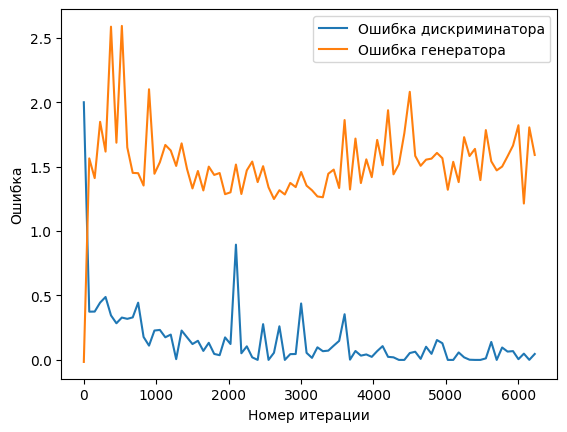

In [27]:

plt.xlabel("Номер итерации")
plt.ylabel("Ошибка")
plt.plot(steps[::75], d_losses[::75], label="Ошибка дискриминатора")
plt.plot(steps[::75], g_losses[::75], label="Ошибка генератора")
plt.legend()
plt.savefig("/kaggle/working/d_g__losses.png")
plt.show()

In [28]:
print(np.mean(d_losses))
print(np.mean(g_losses))

0.17075341646276868
1.531020312775938


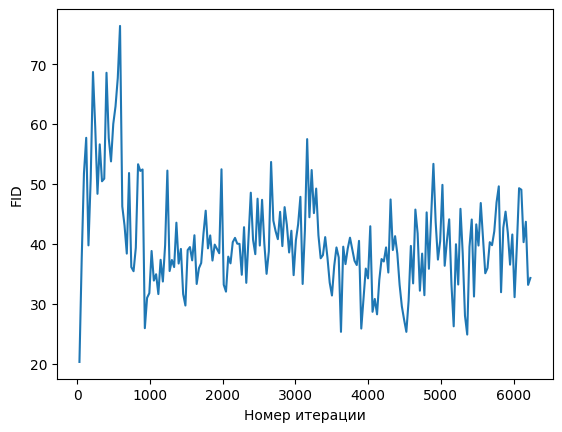

In [29]:
# LOG_FID_INTERVAL+1
# steps_fids = steps[::sagan.fid_interval]
# print(len(steps_fids))

plt.xlabel("Номер итерации")
plt.ylabel("FID")
plt.plot(fids_steps[::], fids[::])
# plt.legend()
plt.savefig("/kaggle/working/fid.png")
plt.show()